# Syntactic embeddings of ontologies

Syntactic embeddings embedding uses the syntax of axioms to generate sentences out of them. mOWL provides methods to generate text sentences from the axioms and/or the annotations in the ontology. The syntax chosen to generate the sentences is [Manchester Syntax](https://www.w3.org/2007/OWL/draft/ED-owl2-manchester-syntax-20081128/).

In [1]:
import mowl
mowl.init_jvm("10g")

We import our `Family Ontology` and the method `extract_axiom_corpus`, which extracts the axioms from the ontology and generates sentences in *Manchester Syntax*.

In [2]:
from mowl.corpus import extract_axiom_corpus
from mowl.datasets import PathDataset
dataset = PathDataset("family.owl")
corpus = extract_axiom_corpus(dataset.ontology)
len(corpus)

INFO:root:Generating axioms corpus


29

Let's see the corpus generated:

In [12]:
for s in corpus[:10]:
    print(s)

http://Melissa Type http://Female
http://Jane Type http://Mother
http://Jane http://hasChild http://Melissa
http://Person DisjointWith owl:Nothing
http://Female and http://Parent SubClassOf http://Mother
http://Parent SubClassOf owl:Thing
 DisjointClasses: http://Father, http://Male, http://Mother, owl:Nothing
 EquivalentClasses: http://Female
http://Mother SubClassOf owl:Thing
http://Parent SubClassOf http://hasChild some http://Person


Now it is possible to input this corpus in a model like Word2Vec, which will generate numerical representations for our vocabulary. We will use the `gensim` library to do this.

In [4]:
from gensim.models import Word2Vec

sentences = [s.split(" ") for s in corpus]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 21 word types from a corpus of 85 raw words and 29 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 21 unique words (100.00% of original 21, drops 0)', 'datetime': '2023-01-21T22:02:56.925128', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 85 word corpus (100.00% of original 85, drops 0)', 'datetime': '2023-01-21T22:02:56.926028', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prepare

INFO:gensim.models.word2vec:EPOCH 50: training on 85 raw words (6 effective words) took 0.0s, 6601 effective words/s
INFO:gensim.models.word2vec:EPOCH 51: training on 85 raw words (15 effective words) took 0.0s, 18249 effective words/s
INFO:gensim.models.word2vec:EPOCH 52: training on 85 raw words (11 effective words) took 0.0s, 16757 effective words/s
INFO:gensim.models.word2vec:EPOCH 53: training on 85 raw words (17 effective words) took 0.0s, 19683 effective words/s
INFO:gensim.models.word2vec:EPOCH 54: training on 85 raw words (9 effective words) took 0.0s, 10229 effective words/s
INFO:gensim.models.word2vec:EPOCH 55: training on 85 raw words (15 effective words) took 0.0s, 9464 effective words/s
INFO:gensim.models.word2vec:EPOCH 56: training on 85 raw words (9 effective words) took 0.0s, 9046 effective words/s
INFO:gensim.models.word2vec:EPOCH 57: training on 85 raw words (21 effective words) took 0.0s, 17272 effective words/s
INFO:gensim.models.word2vec:EPOCH 58: training on 85 r

INFO:gensim.models.word2vec:EPOCH 119: training on 85 raw words (9 effective words) took 0.0s, 11421 effective words/s
INFO:gensim.models.word2vec:EPOCH 120: training on 85 raw words (18 effective words) took 0.0s, 19401 effective words/s
INFO:gensim.models.word2vec:EPOCH 121: training on 85 raw words (21 effective words) took 0.0s, 16551 effective words/s
INFO:gensim.models.word2vec:EPOCH 122: training on 85 raw words (14 effective words) took 0.0s, 15129 effective words/s
INFO:gensim.models.word2vec:EPOCH 123: training on 85 raw words (14 effective words) took 0.0s, 14983 effective words/s
INFO:gensim.models.word2vec:EPOCH 124: training on 85 raw words (14 effective words) took 0.0s, 99848 effective words/s
INFO:gensim.models.word2vec:EPOCH 125: training on 85 raw words (15 effective words) took 0.0s, 16559 effective words/s
INFO:gensim.models.word2vec:EPOCH 126: training on 85 raw words (17 effective words) took 0.0s, 13352 effective words/s
INFO:gensim.models.word2vec:EPOCH 127: tr

INFO:gensim.models.word2vec:EPOCH 188: training on 85 raw words (14 effective words) took 0.0s, 12904 effective words/s
INFO:gensim.models.word2vec:EPOCH 189: training on 85 raw words (12 effective words) took 0.0s, 11135 effective words/s
INFO:gensim.models.word2vec:EPOCH 190: training on 85 raw words (15 effective words) took 0.0s, 16097 effective words/s
INFO:gensim.models.word2vec:EPOCH 191: training on 85 raw words (13 effective words) took 0.0s, 46254 effective words/s
INFO:gensim.models.word2vec:EPOCH 192: training on 85 raw words (16 effective words) took 0.0s, 14385 effective words/s
INFO:gensim.models.word2vec:EPOCH 193: training on 85 raw words (10 effective words) took 0.0s, 7652 effective words/s
INFO:gensim.models.word2vec:EPOCH 194: training on 85 raw words (11 effective words) took 0.0s, 11910 effective words/s
INFO:gensim.models.word2vec:EPOCH 195: training on 85 raw words (14 effective words) took 0.0s, 135095 effective words/s
INFO:gensim.models.word2vec:EPOCH 196: t

Finally, we can provide a visual representation of the entities. We will use a modified version of TSNE, which is implemented in mOWL:

In [5]:
from tsne import TSNE

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

INFO:root:Found 11 embedding vectors. Processing only 11.


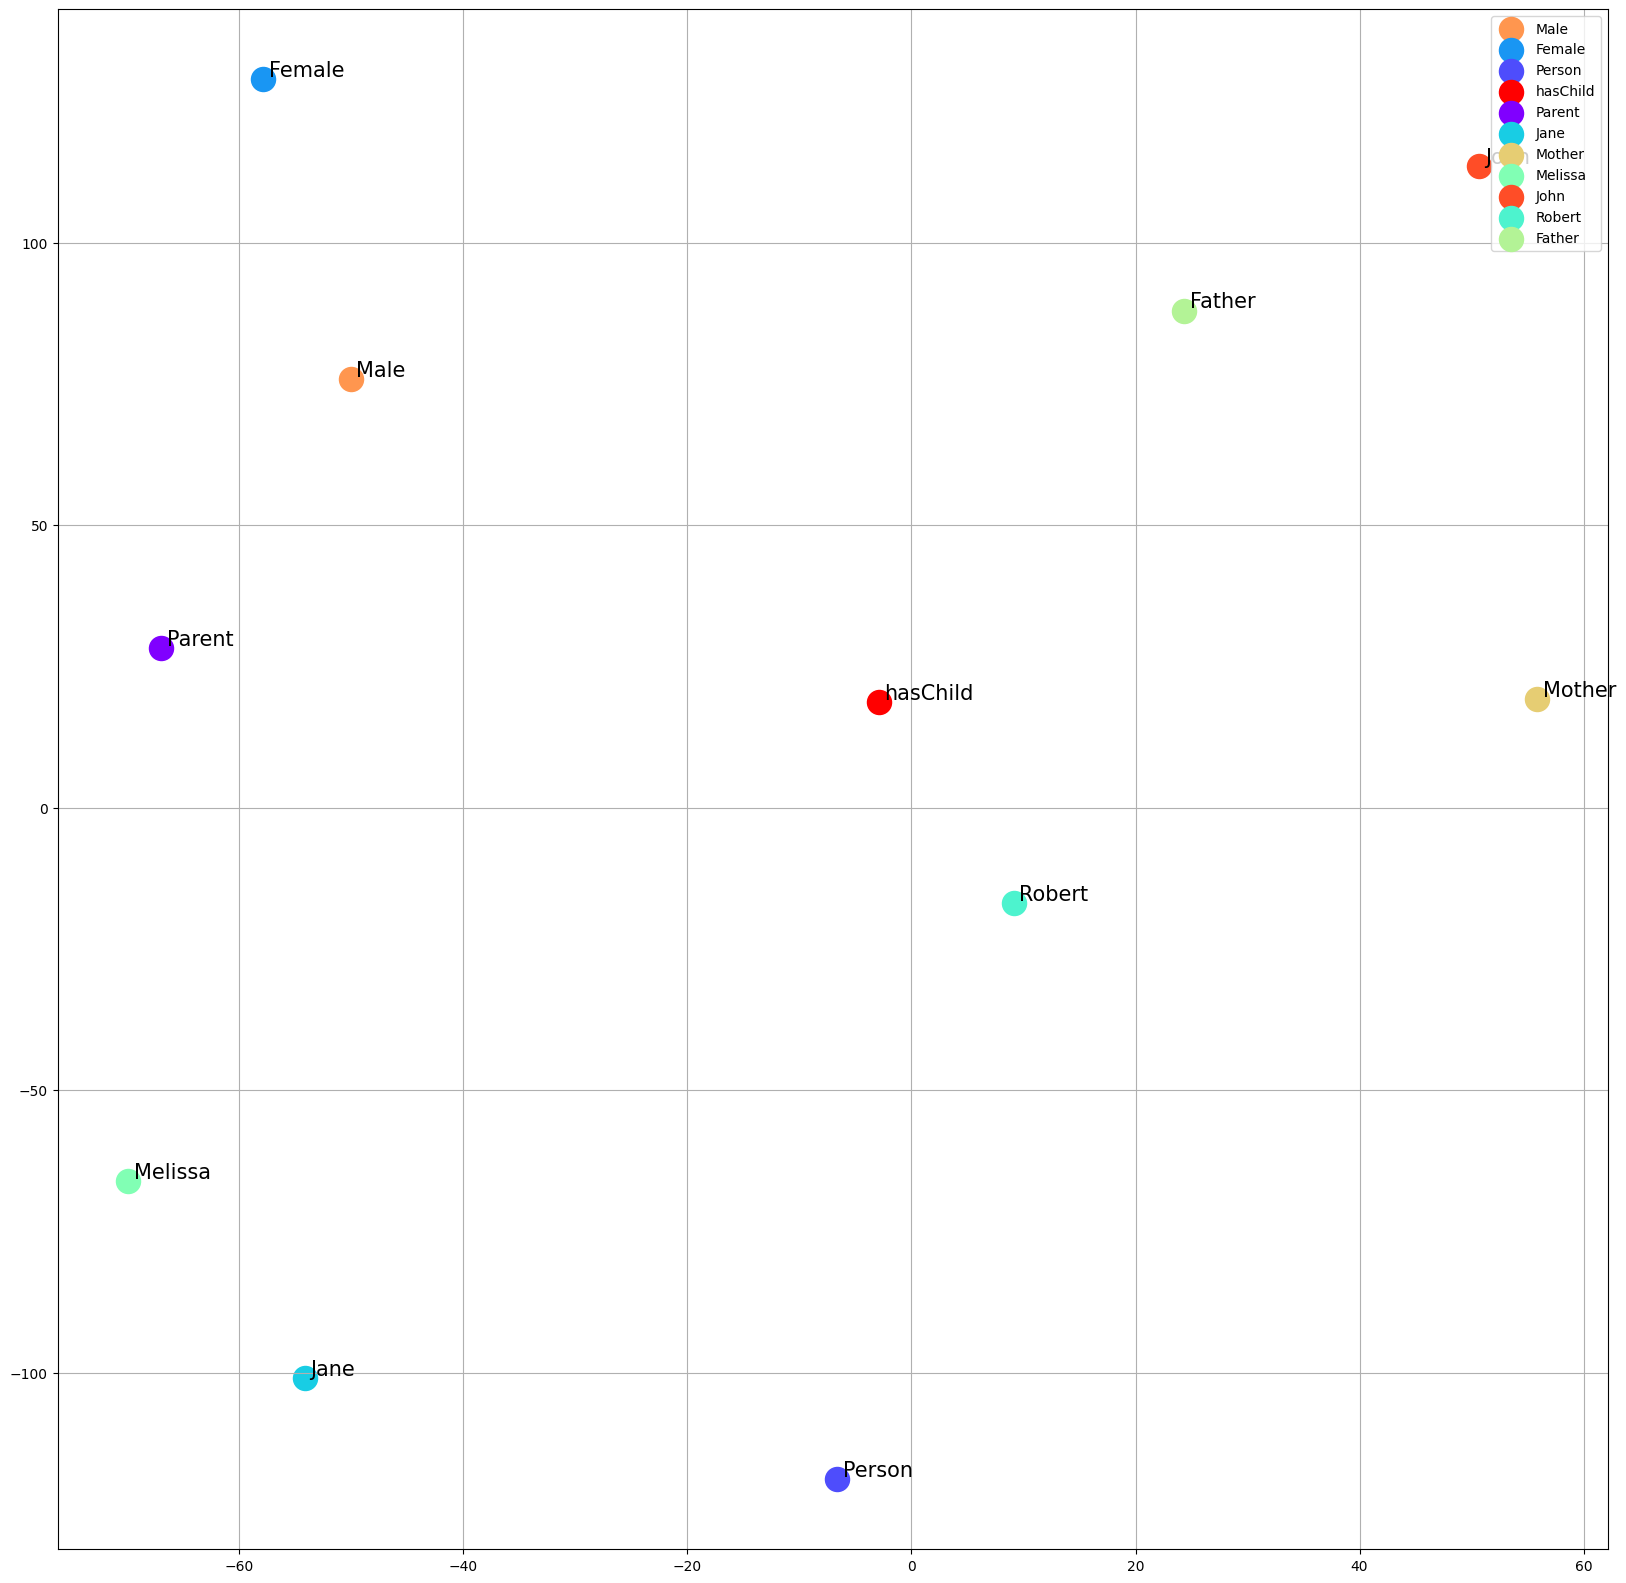

In [6]:
tsne.show(thickness=300)

## Data augmentation via reasoning

We can generate more axioms by performing reasoning over the current ontology. mOWL provides access to ELK and Hermit reasoners. Those reasoners can be accessed using the OWLAPI directly or using the `MOWLReasoner` wrapper class that provides some shortcuts to reasoner methods.

In [7]:
from mowl.reasoning.base import MOWLReasoner
from org.semanticweb.HermiT import Reasoner

reasoner = Reasoner.ReasonerFactory().createReasoner(dataset.ontology)
reasoner.precomputeInferences()

mowl_reasoner = MOWLReasoner(reasoner)
classes_to_infer_over = list(dataset.ontology.getClassesInSignature())

subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes_to_infer_over)
equivalence_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes_to_infer_over)
disjointness_axioms = mowl_reasoner.infer_disjoint_class_axioms(classes_to_infer_over)

INFO:root:Number of inferred axioms: 12.
INFO:root:Number of inferred axioms: 6.
INFO:root:Number of inferred axioms: 6.


Once the axioms were generated, it is time to add them to the ontology:

In [8]:
from mowl.owlapi import OWLAPIAdapter

manager = OWLAPIAdapter().owl_manager

for ax in subclass_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in equivalence_axioms:
    manager.addAxiom(dataset.ontology, ax)
for ax in disjointness_axioms:
    manager.addAxiom(dataset.ontology, ax)

Then we can do the embedding process with the updated ontology:

In [14]:
corpus = extract_axiom_corpus(dataset.ontology)
print(f"The inferred ontology contains {len(corpus)} axioms")

INFO:root:Generating axioms corpus


The inferred ontology contains 48 axioms


In [15]:
sentences = [str(s).split(" ") for s in corpus]
sentences = [[w.replace(",", "") for w in s] for s in sentences]
w2v = Word2Vec(sentences, epochs=200, vector_size = 50, min_count = 0)

vectors = w2v.wv
vocab_dict = vectors.key_to_index
name_to_label = {c: c.split("/")[-1] for c in vocab_dict if str(c).startswith("http://")}
name_to_emb = {c: vectors[[c]][0] for c in name_to_label}

tsne = TSNE(name_to_emb, name_to_label)
tsne.generate_points(500, workers=4)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 27 word types from a corpus of 154 raw words and 48 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 27 unique words (100.00% of original 27, drops 0)', 'datetime': '2023-01-22T00:37:03.657946', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 154 word corpus (100.00% of original 154, drops 0)', 'datetime': '2023-01-22T00:37:03.659598', 'gensim': '4.3.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.15.0-56-generic-x86_64-with-glibc2.10', 'event': 'prep

INFO:gensim.models.word2vec:EPOCH 49: training on 154 raw words (31 effective words) took 0.0s, 112660 effective words/s
INFO:gensim.models.word2vec:EPOCH 50: training on 154 raw words (27 effective words) took 0.0s, 68697 effective words/s
INFO:gensim.models.word2vec:EPOCH 51: training on 154 raw words (24 effective words) took 0.0s, 109434 effective words/s
INFO:gensim.models.word2vec:EPOCH 52: training on 154 raw words (26 effective words) took 0.0s, 124472 effective words/s
INFO:gensim.models.word2vec:EPOCH 53: training on 154 raw words (20 effective words) took 0.0s, 100643 effective words/s
INFO:gensim.models.word2vec:EPOCH 54: training on 154 raw words (31 effective words) took 0.0s, 109117 effective words/s
INFO:gensim.models.word2vec:EPOCH 55: training on 154 raw words (32 effective words) took 0.0s, 89118 effective words/s
INFO:gensim.models.word2vec:EPOCH 56: training on 154 raw words (24 effective words) took 0.0s, 76989 effective words/s
INFO:gensim.models.word2vec:EPOCH 5

INFO:gensim.models.word2vec:EPOCH 117: training on 154 raw words (24 effective words) took 0.0s, 115400 effective words/s
INFO:gensim.models.word2vec:EPOCH 118: training on 154 raw words (30 effective words) took 0.0s, 147839 effective words/s
INFO:gensim.models.word2vec:EPOCH 119: training on 154 raw words (25 effective words) took 0.0s, 68449 effective words/s
INFO:gensim.models.word2vec:EPOCH 120: training on 154 raw words (25 effective words) took 0.0s, 136968 effective words/s
INFO:gensim.models.word2vec:EPOCH 121: training on 154 raw words (25 effective words) took 0.0s, 128422 effective words/s
INFO:gensim.models.word2vec:EPOCH 122: training on 154 raw words (30 effective words) took 0.0s, 108061 effective words/s
INFO:gensim.models.word2vec:EPOCH 123: training on 154 raw words (26 effective words) took 0.0s, 119414 effective words/s
INFO:gensim.models.word2vec:EPOCH 124: training on 154 raw words (33 effective words) took 0.0s, 124781 effective words/s
INFO:gensim.models.word2v

INFO:gensim.models.word2vec:EPOCH 185: training on 154 raw words (21 effective words) took 0.0s, 85442 effective words/s
INFO:gensim.models.word2vec:EPOCH 186: training on 154 raw words (36 effective words) took 0.0s, 91959 effective words/s
INFO:gensim.models.word2vec:EPOCH 187: training on 154 raw words (18 effective words) took 0.0s, 48336 effective words/s
INFO:gensim.models.word2vec:EPOCH 188: training on 154 raw words (35 effective words) took 0.0s, 149480 effective words/s
INFO:gensim.models.word2vec:EPOCH 189: training on 154 raw words (37 effective words) took 0.0s, 157538 effective words/s
INFO:gensim.models.word2vec:EPOCH 190: training on 154 raw words (32 effective words) took 0.0s, 88551 effective words/s
INFO:gensim.models.word2vec:EPOCH 191: training on 154 raw words (21 effective words) took 0.0s, 69000 effective words/s
INFO:gensim.models.word2vec:EPOCH 192: training on 154 raw words (27 effective words) took 0.0s, 122895 effective words/s
INFO:gensim.models.word2vec:E

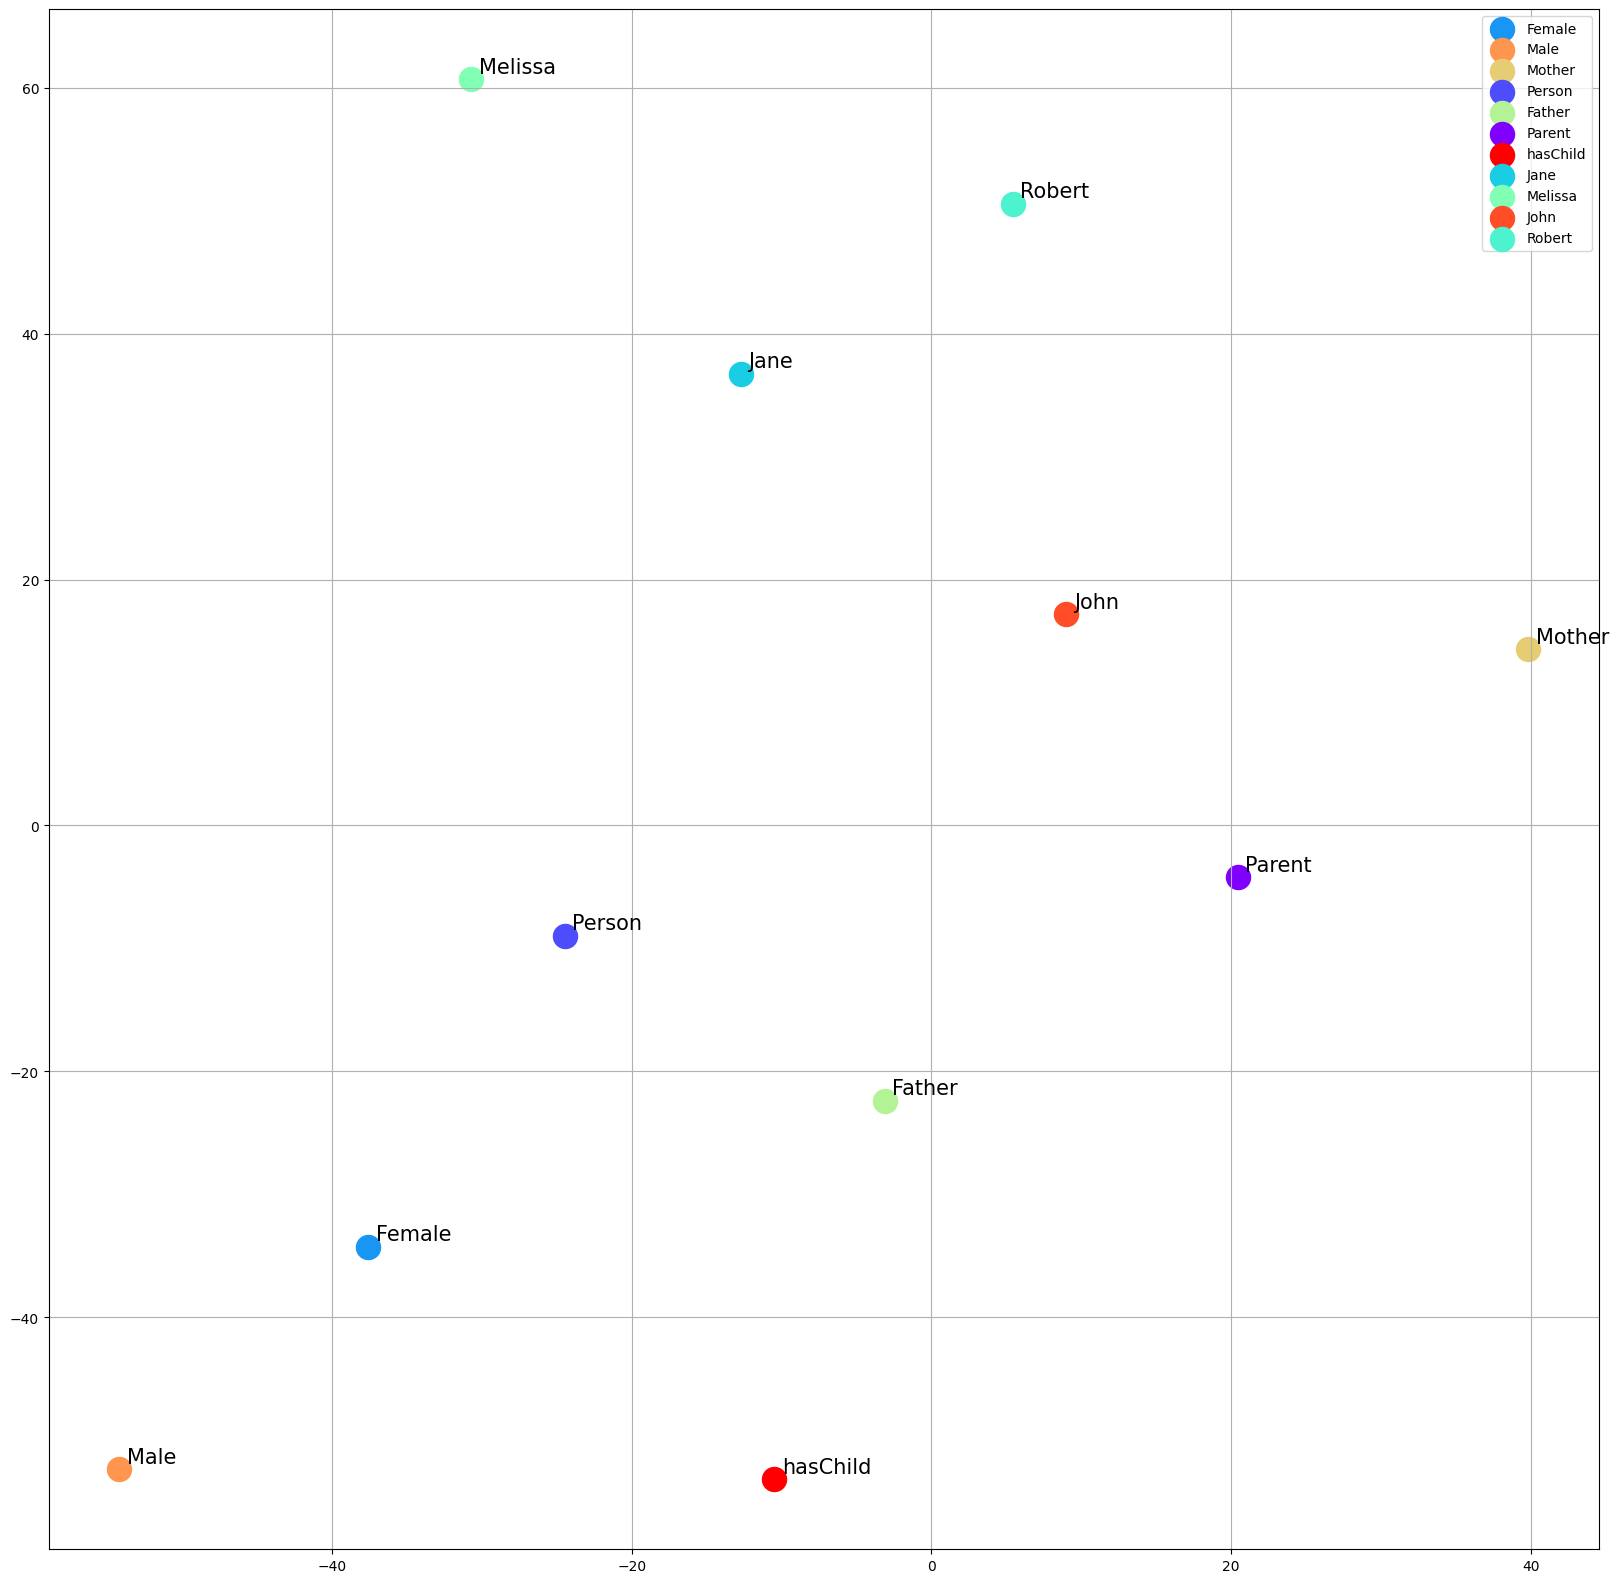

In [11]:
tsne.show(thickness=300)